In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np

# torch.set_default_device('cuda')
np.random.seed(1)
torch.manual_seed(1)

import os, sys
m_path = os.path.abspath("models")
if m_path not in sys.path:
    sys.path.append(m_path)

# load data

In [2]:
import pickle
from models.xcloth.train.data import MeshDataSet

data_path = "models/data/test_data/"
dataset = MeshDataSet(root_dir=data_path, mask={"88-1"}, excld=False, depth_offset=.5)

dataset.stats

{'registered pose': 1,
 'registered mesh': 1,
 'common keys': {'88-1'},
 'extra pose': set(),
 'extra mesh': set()}

In [3]:
d = dataset[0]
print([x.shape for x in d])

[torch.Size([7, 512, 512]), torch.Size([4, 1, 512, 512]), torch.Size([4, 3, 512, 512]), torch.Size([3, 3, 512, 512])]


In [4]:
from matplotlib import pyplot as plt

img = d[0][:3].cpu().numpy()
plt.imsave("input.png", np.moveaxis(img, 0, -1), origin="lower")

In [5]:
img.shape

(3, 512, 512)

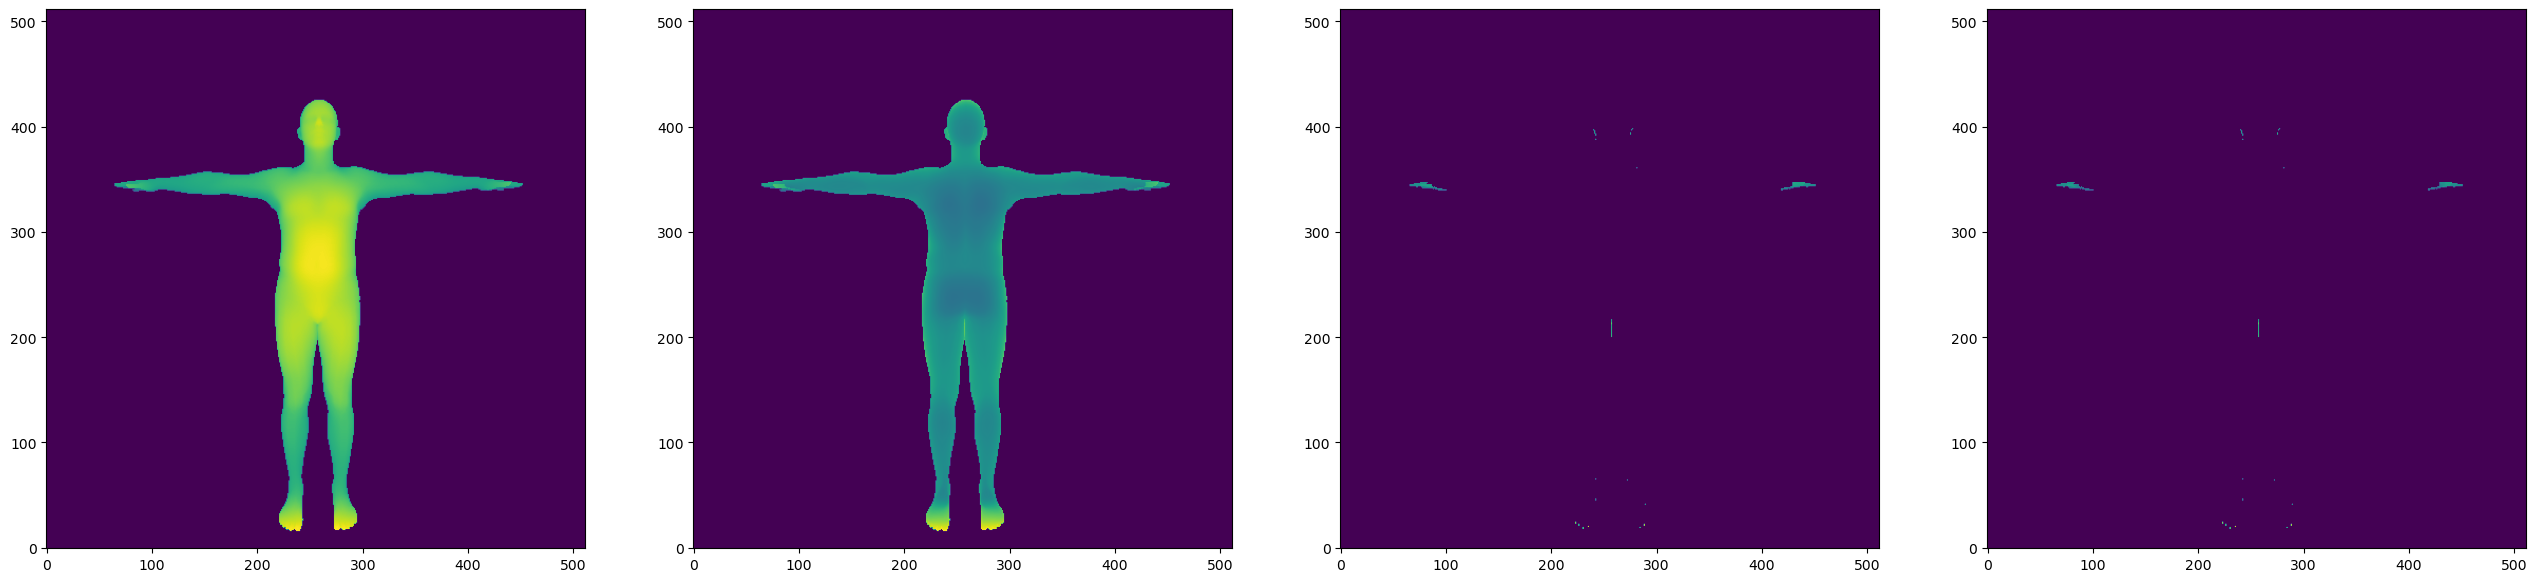

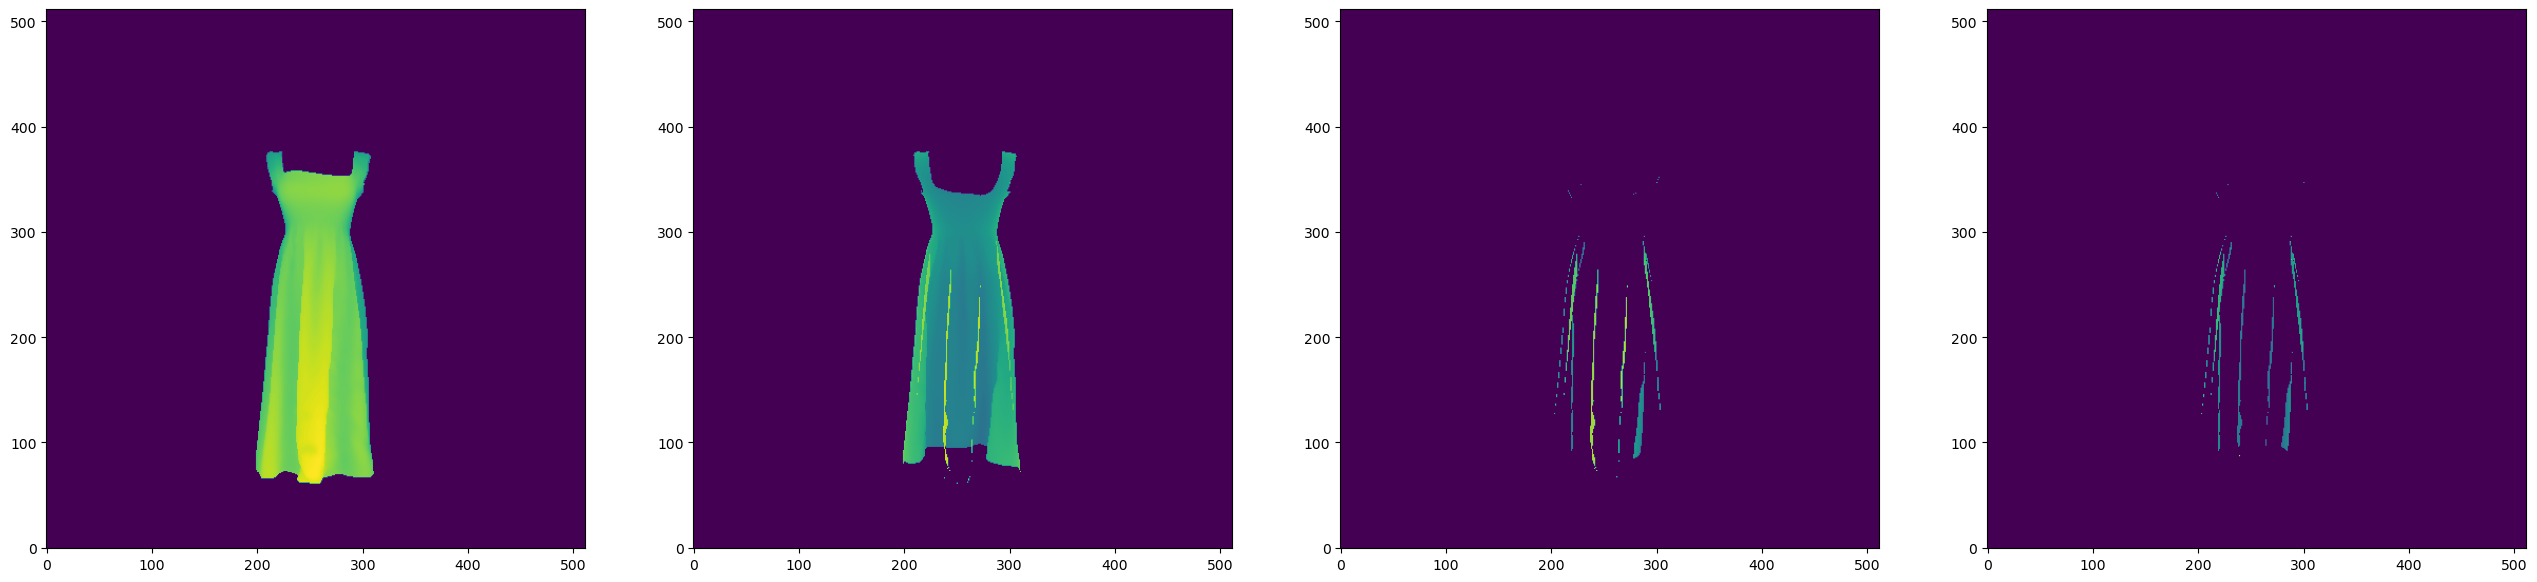

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


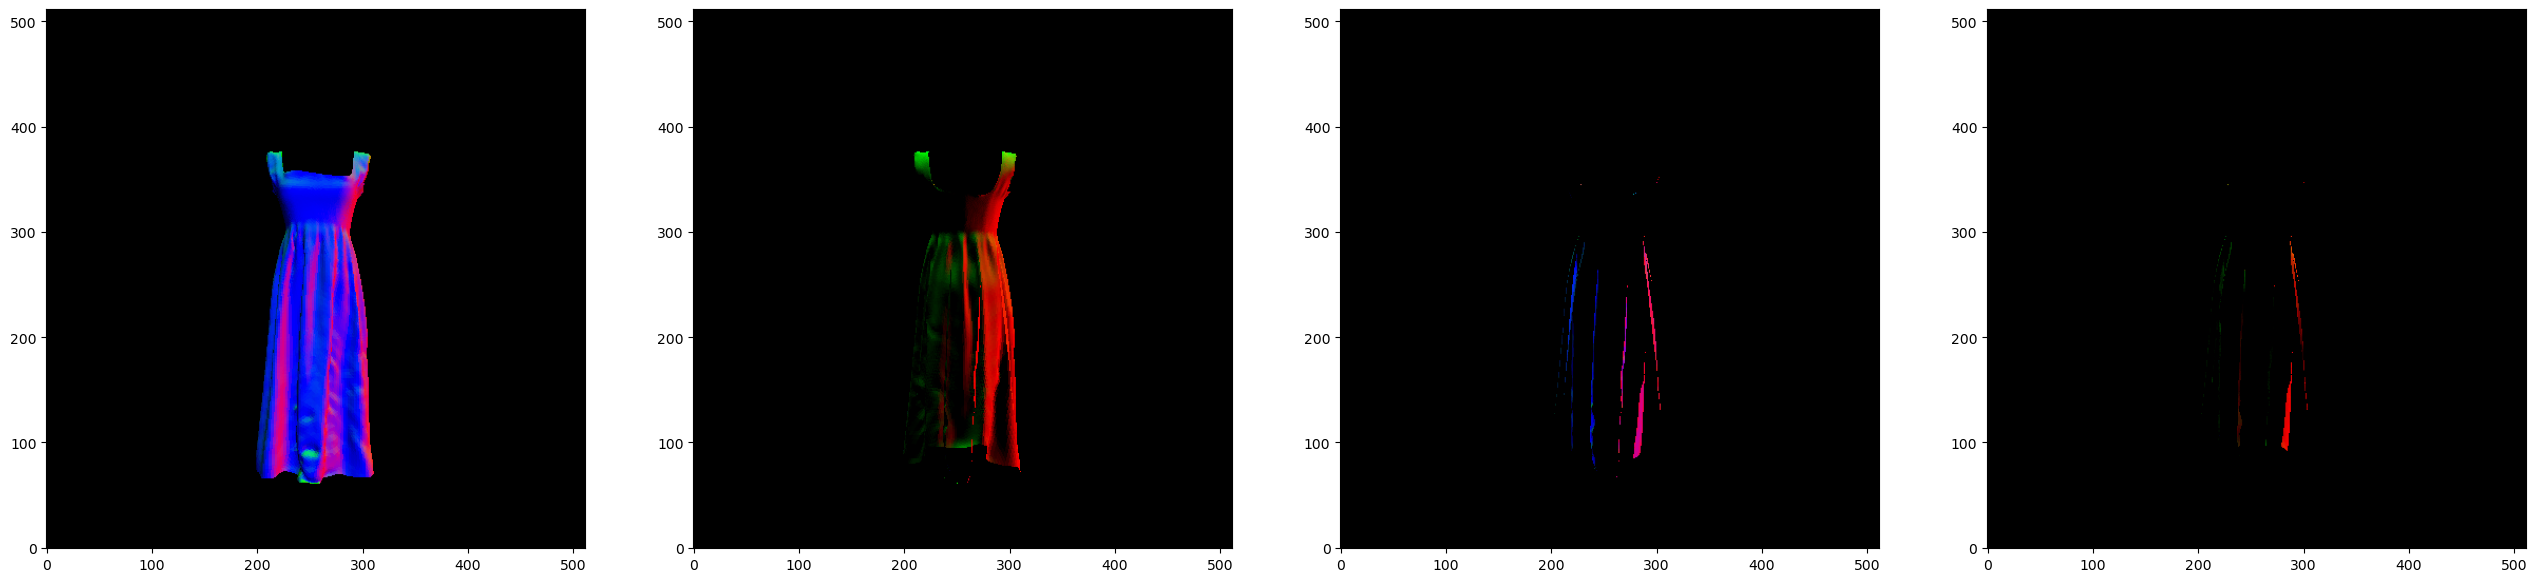

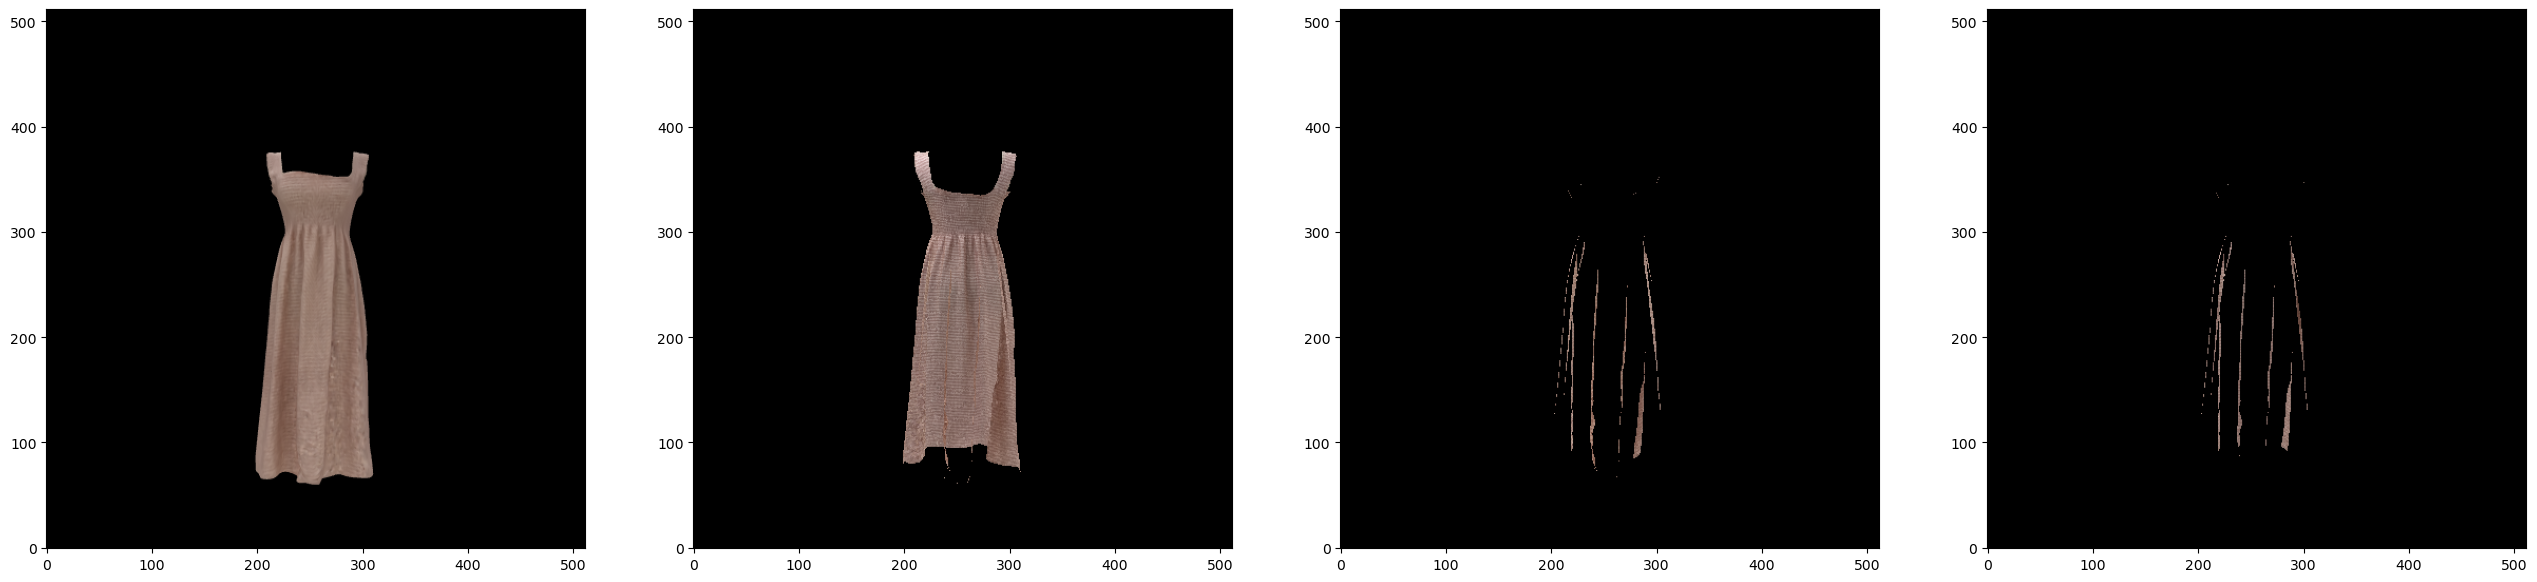

In [6]:
from matplotlib import pyplot as plt
from models.xcloth.utils import plot_3d, plot_depth

plot_depth(d[0][3:].cpu().numpy())
plot_depth(d[1].cpu().numpy().squeeze())
plot_3d(d[2].cpu().numpy())
plot_3d(np.concatenate([d[0][:3].unsqueeze(0).cpu().numpy(), d[3].cpu().numpy()], axis=0))

In [7]:
%%script skip

from models.xcloth.components.utils import GarmentModel3D

garment = GarmentModel3D(
    img=d[0][:3].cpu().numpy(),
    pm_depth=d[1].cpu().numpy(),
    pm_norm=d[2].cpu().numpy(),
    pm_rgb=d[3].cpu().numpy(),
).make_rgb()

garment.reconstruct(thres=0, depth_offset=.5)
garment.save_pcd("models/xcloth/no_git_test_data/88-1/reconstructed")

Couldn't find program: 'skip'


In [8]:
%%script skipped

from models.xcloth.train.trainer import train_model
from models.xcloth.production import XCloth

xcloth = XCloth().cuda()
# xcloth(sample_in, sample_smpl)

train_model(
    xcloth,
    dataset,
    verbose=True,
    n_epoch=5,
    reduction="mean",
    weight=[1., 0.1, 1., 0.05, 1, 0.5],
    params_path="models/data/test_data/params.pt",
    separate_bg=True,
)

Couldn't find program: 'skipped'


In [9]:
from models.xcloth.production import XCloth

model = XCloth().to(device="cpu")
model.load("models/res/xcloth/07-02-2024/xcloth_tm.pt")

sample = d[0]
thres = 0.4

with torch.no_grad():
    r = model(sample[:3], sample[3:])

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


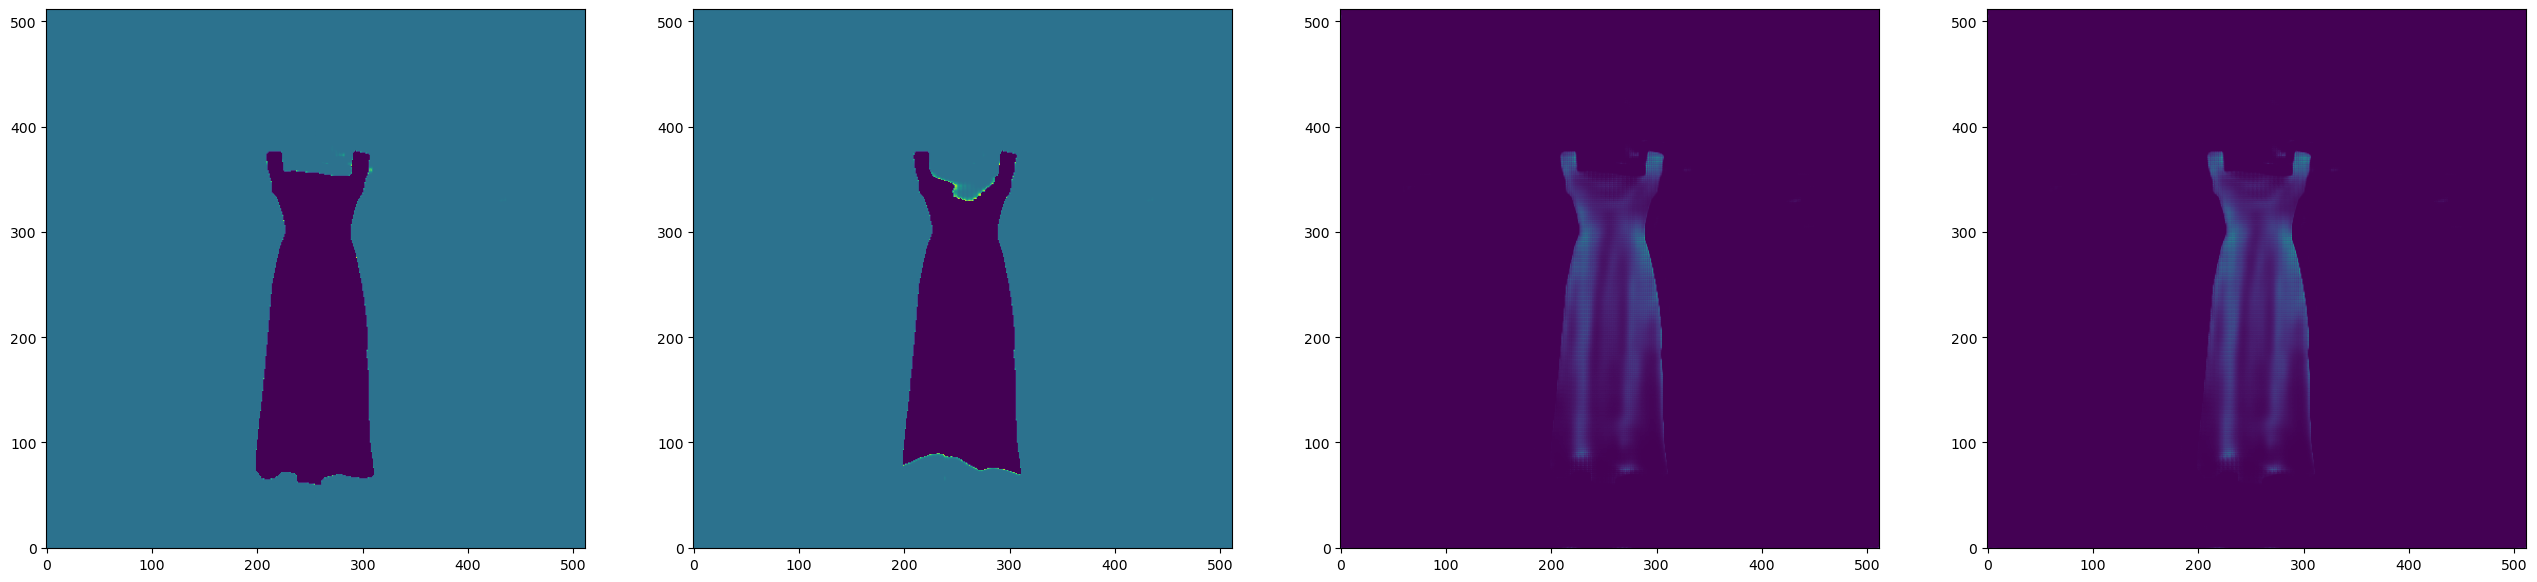

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


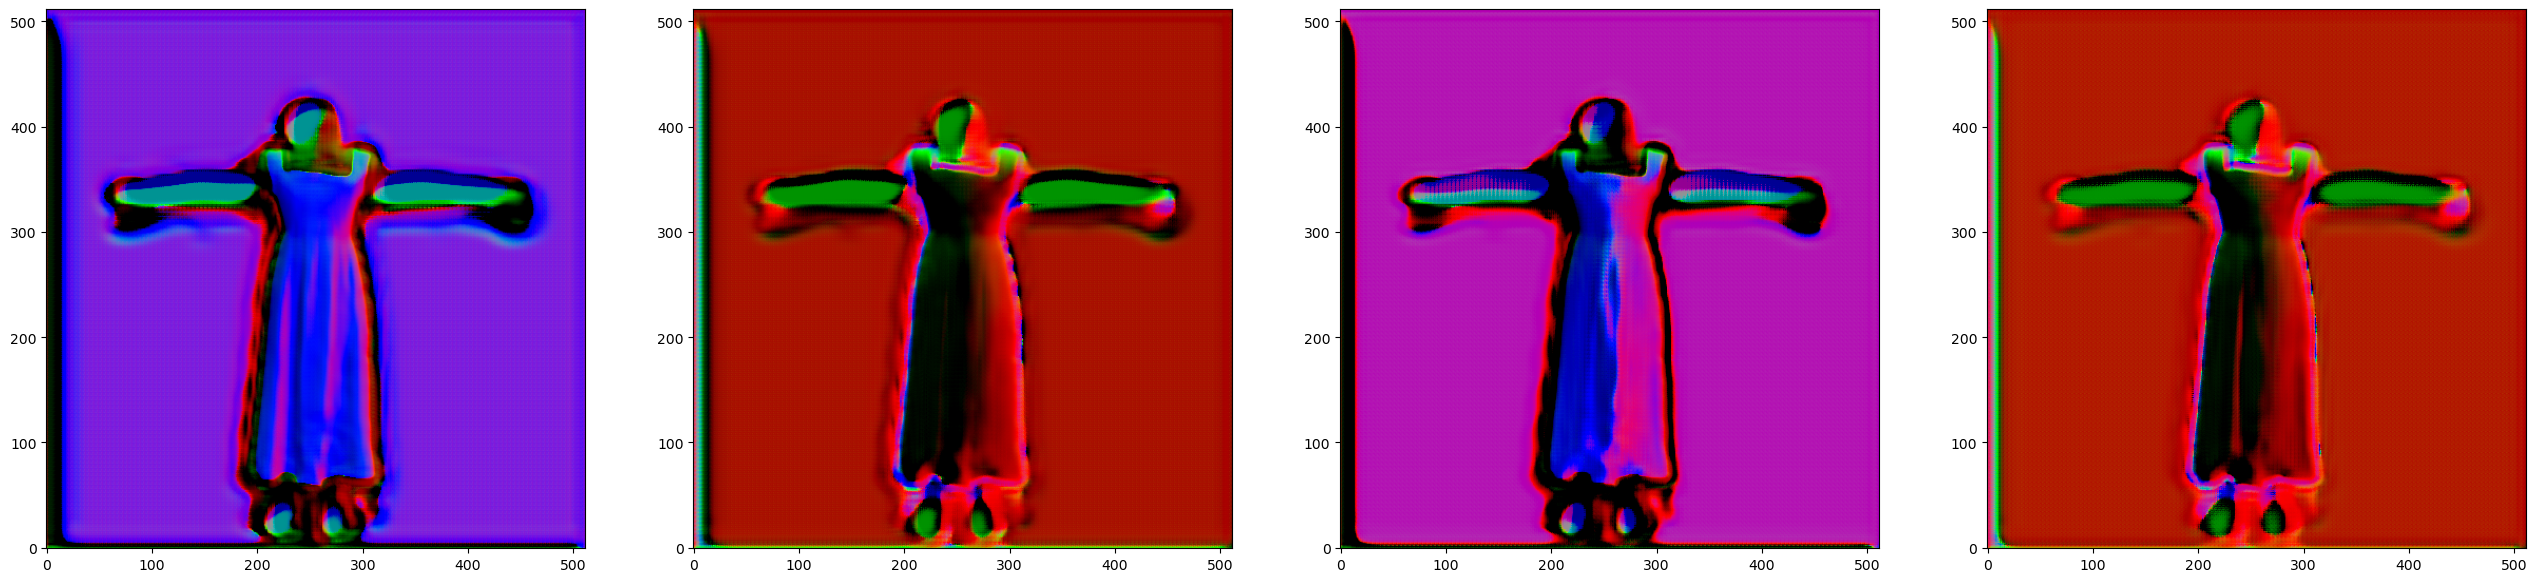

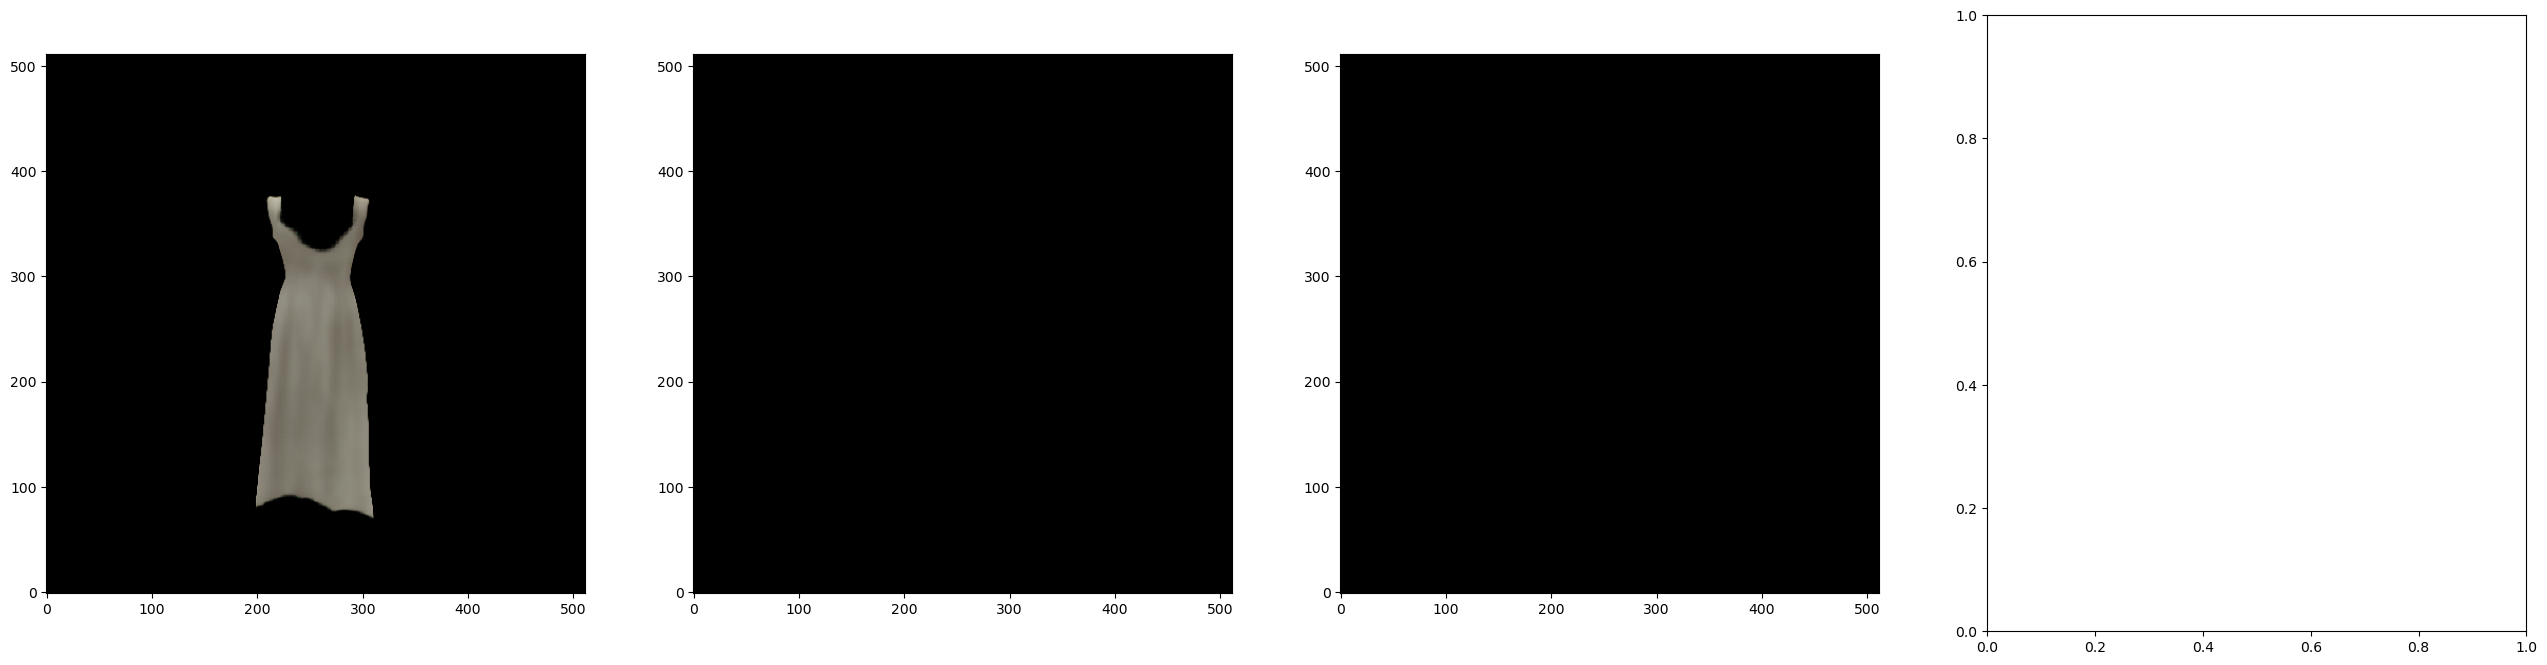

In [10]:
tmp = r["Depth"][0].cpu().detach().numpy().squeeze() - .5
tmp[np.abs(tmp) < thres] = 0
plot_depth(tmp)
plot_3d((r["Norm"][0].cpu().detach().numpy()))
plot_3d((r["RGB"][0].cpu().detach().numpy()))

In [11]:
from models.xcloth.components.reconstruct import GarmentModel3D

mesh = GarmentModel3D.from_tensor_dict(r, 1)

# mesh[0].mask = d[1][0].squeeze().cpu().numpy()
# mesh[0].mask = mesh[0].mask != 0

path = "models/xcloth/no_git_test_data/pcd/88-1_r"

lowpoly = mesh[0].backproject(thres=thres, depth_offset=.5, path=path, denoise_dist=0.01)

In [17]:
m = mesh[0].to_static_mesh(
    path=os.path.join(path, "filtered"), 
    smooth_iter=10, 
    smooth_lambda=0.7, 
    # sampler_mesh=lowpoly, 
    sampler_depth=7,
    sampler_dilation=0.4,
    file_extension="glb"
)